In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [28]:
! python notebook2script.py 01_matmul_perso.ipynb

Converted 01_matmul_perso.ipynb to exp/nb_01.py


# Create test func

In [27]:
#export
from exp.nb_00 import *
import operator
from torch import allclose

def test(a,b,cmp, cname='None'):
    if cname is None: cname=cmp.__name__
    assert cmp(a,b), f"{cname}:\n{a}\n{b}"
    
    
def test_eq(a,b): return test(a,b,operator.eq, "==")

def near(a,b): return allclose(a,b, rtol=1e-3, atol=1e-5)

def test_near(a,b): return test(a,b,near,'near')

# Get data

In [6]:
#export
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor

MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

In [12]:
path = datasets.download_data(MNIST_URL, ext='.gz')
path

PosixPath('/root/.fastai/data/mnist.pkl.gz')

In [13]:
with gzip.open(path, 'rb') as f:
    #((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    p = pickle.load(f, encoding='latin-1')

In [28]:
((x_train, y_train), (x_valid, y_valid), _) = p

In [30]:
x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))

In [31]:
nr, nc = x_train.shape

In [32]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

(torch.Size([50000, 784]),
 torch.Size([50000]),
 torch.Size([10000, 784]),
 torch.Size([10000]))

In [35]:
assert nr == y_train.shape[0] == 50000

In [37]:
test_eq(nc, 28*28)

In [38]:
img = x_train[1000]

In [39]:
mpl.rcParams['image.cmap']='gray'

In [40]:
img.shape

torch.Size([784])

In [42]:
img.view(28,28).type

<function Tensor.type>

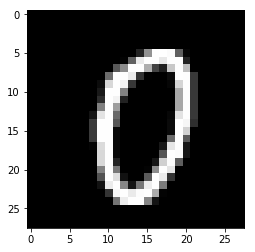

In [44]:
plt.imshow(img.view(28,28))

# MatMul

In [10]:
w = torch.randn(784, 10)
b = torch.zeros(10)

In [9]:
m1 = x_train[:5]
m1.shape

NameError: name 'x_train' is not defined

## 3 loops

In [49]:
def matmul1(a,b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac==br
    
    res = torch.zeros(ar, bc)
    
    for i in range(ar):
        for j in range(bc):
            for k in range(ac):
                res[i,j] += a[i,k] * b[k,j]
    return res

In [50]:
matmul1(m1,w)

tensor([[  6.1764,  -8.8623,   7.3116,  -5.6778,  -4.4061,   9.3887,  -5.7118,
          -7.1170,  10.8090,  -2.7225],
        [  3.5490,   5.6103,   6.9437,  -3.8709, -10.3202,  12.1097, -10.7375,
         -12.9388,  -4.0581,   5.8031],
        [-10.6613,  10.3225,   1.8483,  -3.5724,   5.0247,  -6.1577,  -8.1647,
          -2.0899,  -2.4536,  -2.0688],
        [ 18.3916,   4.6564,  14.6999,  -3.9459,  -4.0783,  -4.8844,   9.6662,
           1.4866,   5.3147,  -8.9346],
        [-16.5931,   8.3669,   2.2423,  -4.6848,   1.3967,  15.4392,  -4.1707,
          -3.3135,   6.0793,   3.7698]])

In [52]:
%timeit -n 10 _=matmul1(m1, w)

805 ms ± 33.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## 2 loops

In [56]:
def matmul2(a,b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac==br
    
    res = torch.zeros(ar, bc)
    
    for i in range(ar):
        for j in range(bc):
            res[i,j] = (a[i] * b[:,j]).sum()
    return res

In [57]:
matmul2(m1,w)

tensor([[  6.1764,  -8.8623,   7.3115,  -5.6778,  -4.4061,   9.3887,  -5.7118,
          -7.1170,  10.8090,  -2.7225],
        [  3.5490,   5.6103,   6.9437,  -3.8709, -10.3202,  12.1097, -10.7375,
         -12.9388,  -4.0581,   5.8031],
        [-10.6613,  10.3225,   1.8483,  -3.5724,   5.0247,  -6.1577,  -8.1647,
          -2.0899,  -2.4536,  -2.0688],
        [ 18.3916,   4.6564,  14.6999,  -3.9459,  -4.0783,  -4.8844,   9.6662,
           1.4866,   5.3147,  -8.9346],
        [-16.5931,   8.3669,   2.2423,  -4.6848,   1.3967,  15.4392,  -4.1707,
          -3.3135,   6.0793,   3.7698]])

In [60]:
%timeit -n 10 _=matmul2(m1,w)

1.33 ms ± 807 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## 1 loop

In [74]:
m1[0][:, None].shape

torch.Size([784, 1])

In [12]:
def matmul3(a,b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac==br
    
    res = torch.zeros(ar, bc)
    
    for i in range(ar):
        res[i] = (a[i][:,None] * b).sum(dim=0)
    
    return res
    

In [71]:
matmul3(m1,w)

tensor([[  6.1764,  -8.8623,   7.3116,  -5.6778,  -4.4061,   9.3887,  -5.7118,
          -7.1170,  10.8090,  -2.7225],
        [  3.5490,   5.6103,   6.9437,  -3.8709, -10.3202,  12.1097, -10.7375,
         -12.9388,  -4.0581,   5.8031],
        [-10.6613,  10.3225,   1.8483,  -3.5724,   5.0247,  -6.1577,  -8.1647,
          -2.0899,  -2.4536,  -2.0688],
        [ 18.3916,   4.6564,  14.6999,  -3.9459,  -4.0783,  -4.8844,   9.6662,
           1.4866,   5.3147,  -8.9346],
        [-16.5931,   8.3669,   2.2423,  -4.6848,   1.3967,  15.4392,  -4.1707,
          -3.3135,   6.0793,   3.7698]])

In [72]:
%timeit -n 10 _=matmul3(m1,w)

297 µs ± 57.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Einsum

In [78]:
def matmul4(a,b):
    return torch.einsum('ik,kj->ij', a,b)

In [79]:
matmul4(m1,w)

tensor([[  6.1764,  -8.8623,   7.3115,  -5.6778,  -4.4061,   9.3887,  -5.7118,
          -7.1170,  10.8090,  -2.7225],
        [  3.5490,   5.6103,   6.9437,  -3.8709, -10.3202,  12.1097, -10.7375,
         -12.9388,  -4.0581,   5.8031],
        [-10.6613,  10.3225,   1.8484,  -3.5724,   5.0247,  -6.1577,  -8.1647,
          -2.0899,  -2.4536,  -2.0688],
        [ 18.3916,   4.6564,  14.6999,  -3.9459,  -4.0783,  -4.8844,   9.6662,
           1.4866,   5.3147,  -8.9346],
        [-16.5931,   8.3669,   2.2423,  -4.6848,   1.3967,  15.4392,  -4.1707,
          -3.3135,   6.0793,   3.7698]])

In [80]:
%timeit -n 10 _=matmul4(m1,w)

52.6 µs ± 9.16 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Torch matmul

In [11]:
def matmul5(a,b): return a@b

In [82]:
matmul5(m1,w)

tensor([[  6.1764,  -8.8623,   7.3115,  -5.6778,  -4.4061,   9.3887,  -5.7118,
          -7.1170,  10.8090,  -2.7225],
        [  3.5490,   5.6103,   6.9437,  -3.8709, -10.3202,  12.1097, -10.7375,
         -12.9388,  -4.0581,   5.8031],
        [-10.6613,  10.3225,   1.8484,  -3.5724,   5.0247,  -6.1577,  -8.1647,
          -2.0899,  -2.4536,  -2.0688],
        [ 18.3916,   4.6564,  14.6999,  -3.9459,  -4.0783,  -4.8844,   9.6662,
           1.4866,   5.3147,  -8.9346],
        [-16.5931,   8.3669,   2.2423,  -4.6848,   1.3967,  15.4392,  -4.1707,
          -3.3135,   6.0793,   3.7698]])

In [83]:
%timeit -n 10 _=matmul5(m1,w)

11.6 µs ± 5.09 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Export scripts